# GAN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
import torch
from fastai.vision.all import *
from fastai.vision.gan import *
from torch import nn
from torch.utils.data import Dataset
import random
import matplotlib.pyplot as plt

In [3]:
print(fastai.__version__) # version check

2.7.15


### Data

In [4]:
embedding = torch.load('embedding.pkl')

In [11]:
class Txt2ImgDataset(Dataset):
    def __init__(self, items, embedding=embedding):
        self.items = items
        self.embedding = embedding

    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        fn = self.items[idx]
        key = fn.name.split('.')[0] + '.txt'
        
        if key not in self.embedding:
            # Handle case where embedding for key is not found
            print(f"Embedding not found for key: {key}")
            return None
        
        emb = self.embedding[key]
        img = PILImage.create(fn).resize((128, 128))  # Ensure the image is resized to 128x128
        wrong_img = self.get_wrong_image(idx)
        noise = torch.randn(100, 1, 1)
        emb_with_noise = torch.cat([emb, noise], 0)
        return emb, tensor(img).permute(2, 0, 1).float() / 255.0, emb_with_noise, tensor(wrong_img).permute(2, 0, 1).float() / 255.0, fn.name

    def get_wrong_image(self, idx):
        cat = '_'.join(self.items[idx].name.split('_')[:-3])
        wrong_idx = random.choice(range(len(self.items)))
        while '_'.join(self.items[wrong_idx].name.split('_')[:-3]) == cat:
            wrong_idx = random.choice(range(len(self.items)))
        wrong_fn = self.items[wrong_idx]
        wrong_img = PILImage.create(wrong_fn).resize((128, 128))  # Ensure the wrong image is resized to 128x128
        return wrong_img


In [12]:
def verify_dataset(dataset, num_samples=5):
    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        sample = dataset[idx]
        
        if sample is None:
            continue
        
        emb, img, emb_with_noise, wrong_img, img_name = sample
        
        print(f"Sample {i + 1} - Image: {img_name}")
        print(f"Embedding shape: {emb.shape}")
        print(f"Image shape: {img.shape}")
        print(f"Embedding with noise shape: {emb_with_noise.shape}")
        print(f"Wrong image shape: {wrong_img.shape}")
        
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(img.permute(1, 2, 0))
        axs[0].set_title("Correct Image")
        axs[1].imshow(wrong_img.permute(1, 2, 0))
        axs[1].set_title("Wrong Image")
        plt.show()


In [16]:
### DataBlock and DataLoaders
def get_dls(path, bs):
    items = get_image_files(path)
    dset = Txt2ImgDataset(items)
    return DataLoaders.from_dsets(dset, dset, bs=bs)

dls = get_dls('data/images/train', bs=64)

Sample 1 - Image: Loggerhead_Shrike_0065_104856_2.jpg
Embedding shape: torch.Size([400, 1, 1])
Image shape: torch.Size([3, 128, 128])
Embedding with noise shape: torch.Size([500, 1, 1])
Wrong image shape: torch.Size([3, 128, 128])


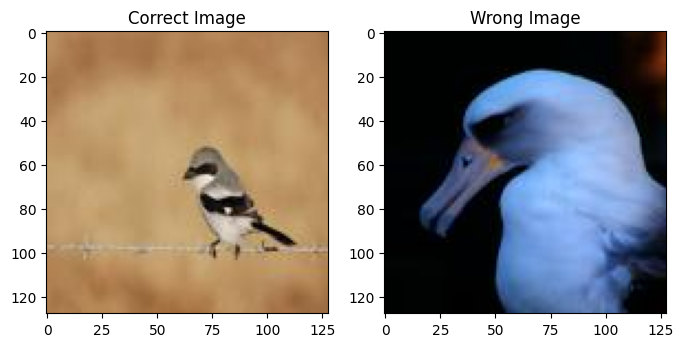

Sample 2 - Image: Orchard_Oriole_0004_91275_2.jpg
Embedding shape: torch.Size([400, 1, 1])
Image shape: torch.Size([3, 128, 128])
Embedding with noise shape: torch.Size([500, 1, 1])
Wrong image shape: torch.Size([3, 128, 128])


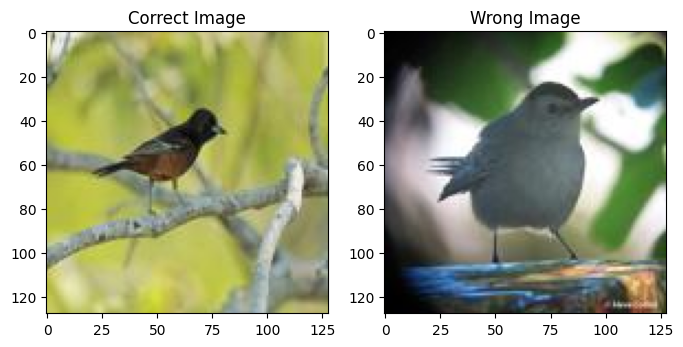

Sample 3 - Image: Mourning_Warbler_0077_166567_4.jpg
Embedding shape: torch.Size([400, 1, 1])
Image shape: torch.Size([3, 128, 128])
Embedding with noise shape: torch.Size([500, 1, 1])
Wrong image shape: torch.Size([3, 128, 128])


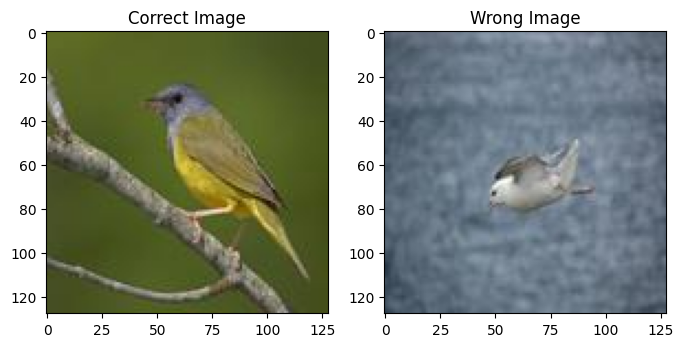

Sample 4 - Image: Northern_Fulmar_0039_43689_2.jpg
Embedding shape: torch.Size([400, 1, 1])
Image shape: torch.Size([3, 128, 128])
Embedding with noise shape: torch.Size([500, 1, 1])
Wrong image shape: torch.Size([3, 128, 128])


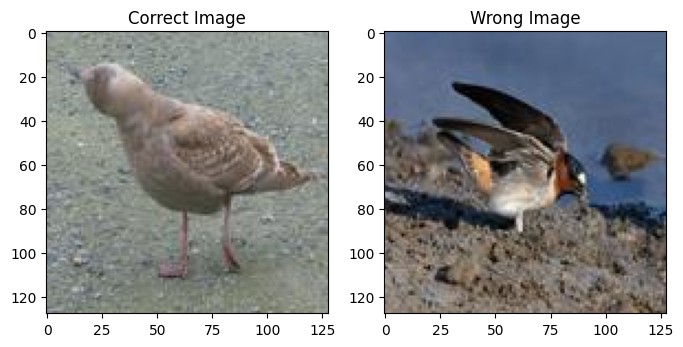

Sample 5 - Image: Ringed_Kingfisher_0060_73132_1.jpg
Embedding shape: torch.Size([400, 1, 1])
Image shape: torch.Size([3, 128, 128])
Embedding with noise shape: torch.Size([500, 1, 1])
Wrong image shape: torch.Size([3, 128, 128])


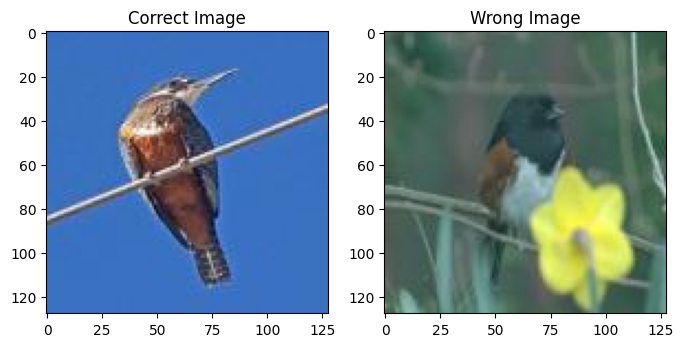

In [19]:
# Verify the dataset
verify_dataset(dls.train_ds, num_samples=5)

### GAN Model and Training

In [21]:
class Txt2ImgGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.generator = basic_generator(out_size=128, n_channels=3, noise_sz=228)
        self.squeezer = nn.Sequential(
            nn.Linear(400, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, embedding):
        em_s = self.squeezer(embedding.view(embedding.size(0), -1))
        em_s = em_s[:, :, None, None]
        em_noise = torch.cat([em_s, torch.randn(em_s.size(0), 100, 1, 1).cuda()], 1)
        return embedding, self.generator(em_noise)

In [22]:
class Txt2ImgCritic(nn.Module):
    def __init__(self):
        super().__init__()
        critic = basic_critic(in_size=128, n_channels=3)
        self.body = nn.Sequential(*list(critic.children())[:-2])
        self.head = nn.Sequential(
            nn.Conv2d(640, 1, 4, padding=0),
            nn.Flatten()
        )
        self.squeezer = nn.Sequential(
            nn.Linear(400, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, embedding, image):
        x = self.body(image)
        em_s = self.squeezer(embedding.view(embedding.size(0), -1))
        em_s = em_s[:, :, None, None]
        em_s = em_s.repeat(1, 1, 4, 4)
        x = torch.cat([x, em_s], 1)
        x = self.head(x)
        return x

In [25]:
generator = Txt2ImgGenerator()
critic = Txt2ImgCritic()

TypeError: basic_generator() missing 1 required positional argument: 'out_size'

In [23]:
class Txt2ImgLoss(GANLoss):
    def __init__(self, gan_model):
        super().__init__()
        self.gan_model = gan_model

    def generator(self, output, *target):
        fake_pred = self.gan_model.critic(*output)
        return fake_pred.mean()

    def critic(self, real_pred, embedding, wrong_img=None):
        fake = self.gan_model.generator(embedding.requires_grad_(False))
        fake[1].requires_grad_(True)
        fake_pred = self.gan_model.critic(*fake)
        return real_pred.mean() - fake_pred.mean()

In [24]:
generator = Txt2ImgGenerator()
critic = Txt2ImgCritic()
gan = GANModule(generator, critic)
loss_func = Txt2ImgLoss(gan)

TypeError: basic_generator() missing 1 required positional argument: 'out_size'